This is a heart disease classification project. The dataset contains 21 features and a binary target. There are +22K rows, of which we used 10K.

In [ ]:
#@title Imports

import os
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

%matplotlib inline

#plotting/ EDA
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
!pip install bubble_plot
import bubble_plot
from bubble_plot.utils import get_most_correlated_variables, plot_correlation_matrix
from pandas.plotting import scatter_matrix
import scipy
from scipy.stats import boxcox 
import tableone
from tableone import TableOne 

#pre-processing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# model fitting 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import imblean
from imblearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTENC #SMOTE for Nominal and Continuous features
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

# performance evaluation
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score




In [ ]:
#@title Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading the data

In [ ]:
#@title Data reading
with open('/content/drive/My Drive/Colab Notebooks/datasets/heart_disease_data.csv', 'r') as f:
  #data = pd.read_csv(f)
  #reading only the first 10,000 rows and replacing column names with numbers from zero to 50
  data = pd.read_csv(f, header=0, nrows=10000, names=[str(i) for i in range(22)])


In [ ]:
# renaming the target variable
data.rename(columns={'0':'target'}, inplace=True)
data['target'].value_counts()/len(data) #heart disease= 10%




0.0    0.899
1.0    0.101
Name: target, dtype: float64

# A first look at the data structure

In [ ]:
# first glance at the features, missing data and data types
#data.shape
#data.info()
#data.describe()
#data.head()
#data.shape[0]

,11,12,13,14,15,16,17,18,19,20,21
0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
# looking at the target's distribution, is it imbalanced?
data['target'].value_counts()/len(data)

0.0    0.899
1.0    0.101
Name: target, dtype: float64

### Missing data

In [ ]:
# number of missing data per columns
data.isna().sum()

#percent of missing data per column
data.isna().sum()/len(data)


In [ ]:
# looking at data types: 
#creating lists of column names, for string/boolean and numerical values (excluding the target feature)

#numerical_cols = df[:len(df)-1].describe().columns.tolist()
#categorical_cols = df[:len(df)-1].select_dtypes(exclude=np.number).columns.tolist()

numerical_cols = data[:len(data)-1].select_dtypes(include=np.number).columns.tolist()
#categorical_cols = df[:len(df)-1].select_dtypes(exclude=np.number).columns.tolist()
categorical_cols = [x for x in data.columns if x not in numerical_cols and x!='target']

print("The dataset contains " +str(len(numerical_cols))+ ' numerical features')
print("The dataset contains " +str(len(categorical_cols))+ ' categorical features')

The dataset contains 22 numerical features
The dataset contains 0 categorical features


In [ ]:
data.head()

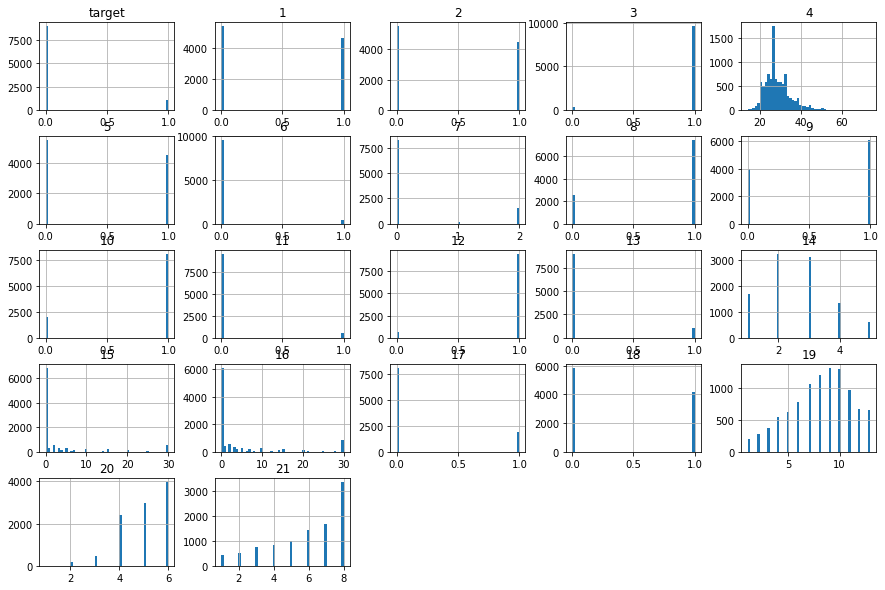

In [ ]:

# visualizing features' distribution with histograms to identify outliers and out-of-range values
# some numerical features may actually be categorical, their distribution is binary or discrete with few values
# features with a highly asymmetric distribution may need to be transformed or discretized 
data.hist(bins=50, figsize=(15,10))
plt.show()



Looks like there are a lot of binary or categorical features. 
Features 14 and 19 are a bit skewed, and features 20 and 21 are heavily skewed, with a long left tail. Features 15 and 16 seem to have been capped, and they may need to be discretized.
Feature 7 has one class that is very small (1.7%) and should be handled.

In [ ]:
data['7'].value_counts()

0.0    8216
2.0    1606
1.0     178
Name: 7, dtype: int64

In [ ]:
# column 7- unifying the small category 1 (1.7%) with the most frequent category- 0
# category 2 is renamed 1
# categories 0 and 1 are renamed 0
data['7'] = np.where(data['7']==2, 1, 0)

# identifying catergorical/numerical features
# choosing features that have up to 4 unique values
categorical_cols = [col for col in data.columns if len(data[col].unique()) <= 4 and col!='target']

# identifying binary features, since they will not require one-hot encoding later on
binary_cols = [col for col in categorical_cols if len(data[col].unique()) == 2]


#creating a list of numerical features 
numerical_cols = [col for col in data.columns if col not in categorical_cols and col!='target']
numerical_cols



['4', '14', '15', '16', '19', '20', '21']

In [ ]:
binary_cols

['1', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13', '17', '18']

(array([7058.,  859.,  287.,  260.,  128.,  239.,  149.,   48.,   54.,
         918.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

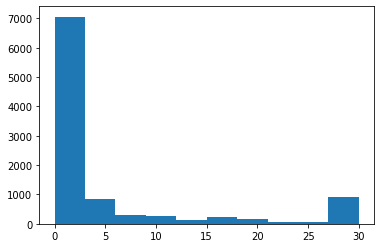

In [ ]:
# looking closely at the distribution of 15 and 16
plt.hist(data['15'])
#plt.hist(data['16'])


It's pretty much the same distribution, we will need to check the correlation between them later

## Data cleaning

# Train-test split

In [ ]:
#train-test split (stratified split)
np.random.seed(42)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["target"]):
    train_set = data.iloc[train_index]
    test_set = data.iloc[test_index]

len(train_set)
len(test_set)

2000

# EDA

In [ ]:
#create a copy of the train set
df=train_set.copy()
df.head()

In [ ]:
df.shape

(8000, 22)

### Numerical features

In [ ]:
#correlations between the target and top 10 features

corr = df.corr()
corr_with_target = corr[['target']].drop('target', axis=0)
corr_with_target['abs_value'] = corr_with_target.abs()
# creating a list of the 10 features which have the highest correlations (in absolute value) to the target
corr_with_target.sort_values(by='abs_value', ascending=False).head(20).drop('abs_value',axis=1)


In [ ]:
# finding the features whose correlation with the target is greater than 0.05
best_features_by_correlation = corr_with_target[corr_with_target.abs_value>0.05].index.values
best_features_by_correlation

In [ ]:
# visualizing numerical features by target, using boxplots

#%matplotlib inline
plt.figure(figsize=(30,5))
for i,col in enumerate(numerical_cols[:-1]):
    plt.subplot(1,len(numerical_cols),i+1)
    sns.boxplot(data=df, x='target',y=col)

In [ ]:
# linear and non-linear correlations between numerical features 

scatter_matrix(df[numerical_cols], figsize=(17, 12))
#scatter_matrix(df[best_features_by_correlation], figsize=(12,8))

[Text(0.5, 0, '4'),
 Text(1.5, 0, '14'),
 Text(2.5, 0, '15'),
 Text(3.5, 0, '16'),
 Text(4.5, 0, '19'),
 Text(5.5, 0, '20'),
 Text(6.5, 0, '21')]

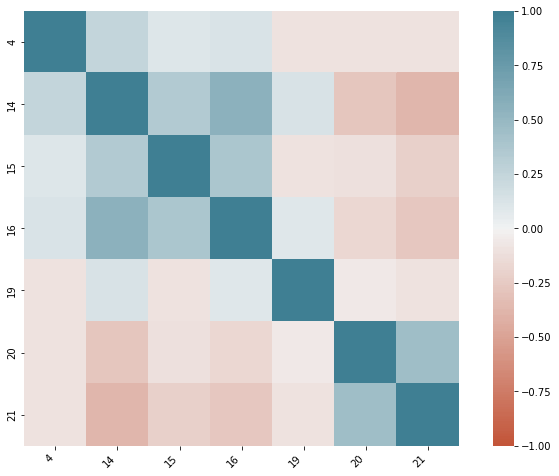

In [ ]:

# correlations between numerical features:
# visualizing correlations using correlation heatmap
# are there visible clusters or multicolinearity? 
# (multicollinearity can lead to an unstable model in Logistic regression)
cor_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12,8))
ax = sns.heatmap(
    cor_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

#figure(figsize=(30, 20))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


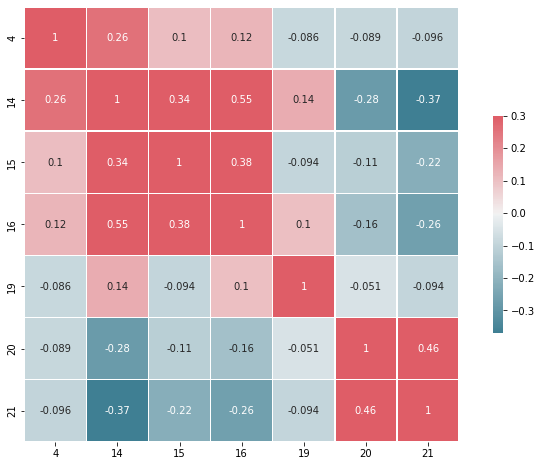

In [ ]:
# another correaltion matrix heatmap- with correlation size on each cell
corr = df[numerical_cols].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True) # In sns.heatmap it will be the mapping from data values to color space
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12,8))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True, # mask -If passed, data will not be shown in cells where mask is True. vmax and center are for setting the colormap values 
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
# finding variables which are strongly correlated to each other
# looking at the top 10 pairs of correlated variables

# top 10 pairs + correlation plot
features = df.columns.tolist()
plot_correlation_matrix(df, features)


In [ ]:
#non-normally distributed features (14, 19, 20, 21): 
# applying transformations log, square and cubic root and box-cox to achieve a distribution that is approximately normal
 
#plt.hist(np.sqrt(df['14']))
#plt.xlabel("feature 14 with log transformation")
#plt.hist(df['19'])
plt.hist(boxcox(df['19']))

Text(0.5, 0, 'feature 20 with log transformation')

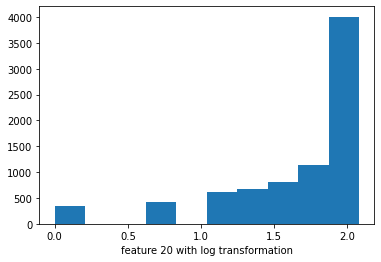

In [ ]:
#applying transformations on features 20 and 21 to achieve a distribution that is approximately normal
plt.hist(np.log(df['21']))
plt.xlabel("feature 20 with log transformation")
#plt.hist(df['19'])

Log transformation works well for feature 14, box-cox for feature 19. features 20 and 21 did not respond well to log, square or cubic root or box-cox transformations.

In [ ]:
# discretizing features 15 

# trying a few options for discretization
df['15_binary'] = np.where(df['15']<=1, 0,1)
df['15_cat'] = np.where(df['15']<=1, 0, np.where(df['15']<25, 1,2))
df['15_cat'].value_counts()/len(df)

# testing which option is the best predictor of the target
cor15 = df[['15', '15_binary', '15_cat', 'target']].corr()  
cor15['target']


15           0.087296
15_binary    0.051569
15_cat       0.072059
target       1.000000
Name: target, dtype: float64

feature 15: The discretized feature  (bins: 1, 2-24, 25+) is nearly as good as the non-nonrmally distributed original feature.

16           0.191110
16_binary    0.145217
16_cat       0.151611
target       1.000000
Name: target, dtype: float64

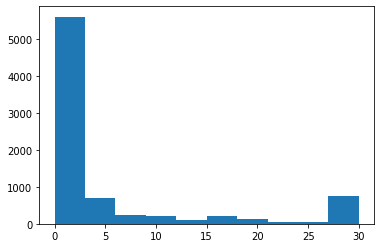

In [ ]:
# discretizing features 16 
plt.hist(df['16'])
# trying a few options for discretization
df['16_binary'] = np.where(df['16']<=1, 0,1)
df['16_cat'] = np.where(df['16']<=1, 0, np.where(df['15']<25, 1,2))
df['16_cat'].value_counts()/len(df)

# testing which option is the best predictor of the target
cor16 = df[['16', '16_binary', '16_cat', 'target']].corr()  
cor16['target']

Feature 16: the binarized/discretized features are less precitive compared to the original feature.

### Categorical features

In [ ]:
# describing the distribution of categorical features with category frequencies
# noticing infrequent/similar categories that should be unified, and missing values

describe_categorical_values(df, non_interesting_columns=numerical_cols, num_categories=6)

In [ ]:

# looking at the correlation between categorical features and the target using cross-tables
# plotting the percent of target=1 in each category for each categorical feature
num_rows = len(categorical_cols)//3 + 1
fig, ax = plt.subplots(num_rows, 3, figsize=(20, 60))
for col, subplot in zip(categorical_cols, ax.flatten()):
  table=pd.crosstab(df[col], df['target'], normalize='index')
  plt.bar(x=table.index, height=table[1])
for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [ ]:
# looking at the correlation between categorical features and the target using cross-tables
for col in categorical_cols:
  print(pd.crosstab(df[col], df['target'], normalize='index').round(2))

All features seem to have different probabilities for the positive class for each category.
Some predictors have a big difference (feature 6: the probaility of target=1 is 0.38 for class 1 vs. 0.9 for class 0) and some do not (feature 9: 0.11 for class 0 and 0.10 for class 1).

Features 1,2,3,6 and 17 look promising while features 9,10,11 and 13 seem redundant in respect to target prediction.


In [ ]:
#categorical_cols
df.columns

In [ ]:
# testing the correlations between target and all features (t-test for numerical vars and chi-squared test for categorical vars)
#!pip install tableone
mytable = TableOne(df, #columns=numerical_cols, 
                   categorical=categorical_cols, 
                   groupby='target', pval=True)

print(mytable.tabulate(tablefmt = "fancy_grid"))

Feature 9 is not statistically significant

#Pre-processing

In [ ]:
# separating the target and the features of the train and the test sets
train_set = train_set.reset_index(drop=True)
train_x = train_set.drop("target", axis=1)
train_y = train_set["target"].copy()

test_set = test_set.reset_index(drop=True)
test_x = test_set.drop("target", axis=1)
test_y = test_set["target"].copy()

preprocessing checklist:

* **imputation** (SimpleImputer, KNNImputer, )
* **transformation**: sqrt, log, cubic root (FunctionTransformer)
* **feature engineering** (custom)
* **discretization** (binarizer, kbinsdiscretizer, better with domain knowledge)
* **ploynomial features** (PolynomialFeatures)
* **scaling** (minmaxscaler (0-1, sensitive to outliers), standard scaler)
* **OHE** (onehotencoding)
* **selection** (SelectKbest, ColumnTransformer drop/passthrough)
* **oversampling** (SMOTE)
* **undersampling** (RandomUnderSampler)

In [ ]:
# creating a pipeline for pre-processing

#basic processing 

#creating a pipeline for numerical features
num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', MinMaxScaler()),
    ])

# creating a pipeline for categorical features
cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    #('ohe', OneHotEncoder()),
])

# both pipeline combined
preprocessing_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_cols),
        ("cat", cat_pipeline, categorical_cols),
    ])

# Model training

## Logistic regression model

In [ ]:
# defining a logistic regression model suited for imbalanced classes
trf_model = LogisticRegression(class_weight='balanced')

# the final pipeline, including a logistic regression model
full_pipeline = Pipeline([('processing', preprocessing_pipeline),
                         #('selecting', SelectKBest(k=30)),
                          ('model', trf_model)
                        ])

# training the model with a stratified 5-fold cross-validation
# the chosen metrics are precision, recall and ROC AUC
for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

Model  roc_auc  mean= 0.83 stddev= 0.01
Model  recall  mean= 0.77 stddev= 0.03
Model  precision  mean= 0.25 stddev= 0.01


the AUC is not bad (0.83), and so is recall (0.77) but precision is low (0.25), which means we have a lot of false positives. For disease detection we would rather have a high false positive rate and a low false negative rate than the other way around, but we could do better.

### Logistic regression with polynomial features for numerical features

In [ ]:
#adding polynomial features for the numerical features
num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('poly_feats', PolynomialFeatures()),
        ('std_scale', MinMaxScaler()),
    ])

# both pipelines combined
preprocessing_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_cols),
        ("cat", cat_pipeline, categorical_cols),
    ])

# the final pipeline, including a logistic regression model
full_pipeline = Pipeline([('processing', preprocessing_pipeline),
                         #('selecting', SelectKBest(k=25)),
                          ('model', trf_model)
                        ])

# training the model with a stratified 5-fold cross-validation
# the chosen metrics are precision, recall and ROC AUC
for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

Model  roc_auc  mean= 0.8 stddev= 0.01
Model  recall  mean= 0.72 stddev= 0.04
Model  precision  mean= 0.23 stddev= 0.01


### Logistic regression with over-sampling and under-sampling


In [ ]:
#https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

# adding over-sampling of the minority class and random under-sampling of the majority class to improve the model's performance

#over and undersampling should be performed only on the train set, as the test set should resemble real data,
# and should not be contain synthetic data. 
# for this reason SMOTE will be applied on the train set outside the pipeline

#creating a list of indices for the categorical features
categorical_ix = [int(col) for col in binary_cols]
categorical_ix

#applying over and under sampling on the train set
oversample = SMOTENC(sampling_strategy=0.3, categorical_features = categorical_ix)
undersample = RandomUnderSampler()
train_x_balanced, train_y_balanced = oversample.fit_resample(train_x, train_y)
train_x_balanced, train_y_balanced = undersample.fit_resample(train_x_balanced, train_y_balanced)

#checking the frequencies of the classes in the target variable, after over and under smapling
#train_y_balanced.value_counts()/len(train_y_balanced)
#we got a 1:1 ratio

# defining a logistic regression model
trf_model = LogisticRegression()

# the final pipeline, including over-sampling and under-sampling, and a logistic regression model
full_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          ('model', trf_model)
                        ])

# training the model with a stratified 5-fold cross-validation
# the chosen metrics are precision, recall and ROC AUC
for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x_balanced, train_y_balanced, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

Model  roc_auc  mean= 0.87 stddev= 0.01
Model  recall  mean= 0.83 stddev= 0.01
Model  precision  mean= 0.77 stddev= 0.02


The model trained using SMOTE is overfitted. Decreasing the ratio improved overfit slightly,but the model trianed on the original dataset performs better.

### Random forest classifier

In [ ]:
# training a random forest classifier, with a hyper-parameter for imbalanced data

trf_model = RandomForestClassifier(class_weight="balanced")
#trf_model = BalancedRandomForestClassifier(class_weight="balanced_subsample")

# the final pipeline, including a random forest model
full_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          #('select', SelectKBest(k=20)),
                          ('model', trf_model)
                        ])

# training the model with a stratified 5-fold cross-validation
for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

very low recall (0.07)

### Easy Ensemble (AdaBoost for imbalanced data)

In [ ]:
# training an ensemble of AdaBoost learners with random under-sampling
trf_model = EasyEnsembleClassifier()

# the final pipeline, including a random forest model
full_pipeline = Pipeline([('impute', SimpleImputer()),
                          #('select', SelectKBest(k=20)),
                          ('model', trf_model)
                        ])

# training the model with a stratified 5-fold cross-validation
for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

### SVC (linear)

In [ ]:
# training a linear support vector machine calssifier
trf_model = LinearSVC(class_weight='balanced', dual=False)

full_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          #('selecting', SelectKBest(k=20)),
                          ('model', trf_model)
                        ])

for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

Model  roc_auc  mean= 0.83 stddev= 0.01
Model  recall  mean= 0.78 stddev= 0.02
Model  precision  mean= 0.25 stddev= 0.01


### SVC (polynomial)

In [ ]:
#training a support vector machine classifier with a polynomial/rbf kernel
trf_model = SVC(class_weight="balanced", kernel='poly')
#trf_model = SVC(class_weight="balanced") #rbf kernel

full_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          #('selecting', SelectKBest(k=20)),
                          ('model', trf_model)
                        ])

for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

Model  roc_auc  mean= 0.79 stddev= 0.01
Model  recall  mean= 0.66 stddev= 0.03
Model  precision  mean= 0.24 stddev= 0.01


### XGBoost

In [ ]:
#training an Extreme Gradient Boosted trees classifier
trf_model = XGBClassifier(scale_pos_weight=20)

full_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          #('selecting', SelectKBest(k=20)),
                          ('model', trf_model)
                        ])

for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

### KNN

In [ ]:
#training a K-nearest neighbors classifier
trf_model = KNeighborsClassifier(n_neighbors=40)

full_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          #('selecting', SelectKBest(k=20)),
                          ('model', trf_model)
                        ])

for scoring in ['roc_auc', 'recall', 'precision']:
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
    scores = cross_val_score(full_pipeline, train_x, train_y, scoring=scoring, cv=cv, n_jobs=-1)
    print("Model ", scoring, " mean=", round(scores.mean(), 2), "stddev=", round(scores.std(), 2))

Model  roc_auc  mean= 0.8 stddev= 0.01
Model  recall  mean= 0.01 stddev= 0.01
Model  precision  mean= 0.36 stddev= 0.31


# Hyper-parameter tuning


The most promising models are:
1. Linear SVC (AUC=0.83, recall=0.78, precision=0.25) 
2. Logistic regression (AUC=0.83, recall=0.77, precision=0.25)
3. XGBoost (AUC=0.82, recall=0.88, precision=0.19)

We will proceed to improve these models with hyper-parameter tuning, using a cross-validation grid search.

In [ ]:
#HP tuning for linear SVC model
trf_model = LinearSVC(class_weight='balanced', dual=False)

svc_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          ('model', trf_model)
                        ])

svc_model = svc_pipeline.fit(train_x, train_y)

# hyper parameter tuning
params = {'model__C': [1, 10, 100, 1000]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(svc_model, param_grid=params,
                    n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
# params = {'model__n_estimators': [10, 100], 'model__max_features': [1:5]}
# grid = GridSearchCV(tree_pipeline, params, cv=5, scoring='f1')
grid.fit(train_x, train_y)
print(grid.best_score_)
#auc=0.637, C=1
print(grid.best_params_)



0.8337881356887138
{'model__C': 100}


In [ ]:
# HP tuning for logistic regression model

trf_model = LogisticRegression(class_weight='balanced')

logreg_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          ('model', trf_model)
                        ])

logreg_model = logreg_pipeline.fit(train_x, train_y)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
params = {'model__C': [1,5,10], 'model__penalty':[ 'l2', 'none']}
#params = {'model__C': [1,5,10]}
#params = {'model__penalty':[ 'none', 'l2']}
#params = {'model__penalty': ['l2'], 'model__solver': ['lbfgs', 'liblinear']}
grid = GridSearchCV(logreg_model, params, cv=cv, scoring='roc_auc')
grid.fit(train_x, train_y)
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
# HP tuning for XGBoost
trf_model = XGBClassifier(scale_pos_weight=20)

xgb_pipeline = Pipeline([('processing', preprocessing_pipeline),
                        ('model', trf_model)
                        ])

xgb_model = xgb_pipeline.fit(train_x, train_y)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
#params = {'model__max_depth': [3,5,7], 'model__learning_rate': [0.1, 0.5]}
params = {'model__n_estimators': [10,100,1000]}
grid = GridSearchCV(xgb_model, params, cv=cv, scoring='roc_auc')
grid.fit(train_x, train_y)
print(grid.best_score_)
print(grid.best_params_)

For all 3 models, the default hyper-parameters showed the best results. We will continue to evaluate the models' performance on the test set.

# Models' performance evaluation

In [ ]:
# helper functions, for display of ROC curve and model's performance metrics
# (based on https://github.com/shirmeir/bubble_plot/blob/master/bubble_plot/utils.py)

def find_best_threshold(thresholds, fpr, tpr):
    """
    find the best threshold from the roc curve. by finding the threshold for the point which is closest to (fpr=0,tpr=1)
    """
    fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
    fpr_tpr['dist'] = (fpr_tpr['fpr'])**2 + (fpr_tpr['tpr']-1)**2
    return fpr_tpr.loc[fpr_tpr.dist.idxmin(), 'thresholds']

def get_model_results(model, train, test, y_train, y_test):
    probabilities = model.predict_proba(test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr)
    predictions = probabilities>threshold
    plt.figure()
    plt.plot(fpr, tpr, label='test')
    roc_auc = roc_auc_score(y_test, probabilities)
    probabilities = model.predict_proba(train)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities)
    plt.plot(fpr, tpr, label='train')
    plt.plot([0, 1], [0, 1], 'r--', label='random guess')
    plt.title("Area under the ROC curve = {:.3f}".format(roc_auc), fontsize=18);
    print(classification_report(y_test, predictions))
    plt.legend()

## Linear SVC

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.82      1798
         1.0       0.24      0.79      0.37       202

    accuracy                           0.73      2000
   macro avg       0.60      0.75      0.60      2000
weighted avg       0.89      0.73      0.78      2000



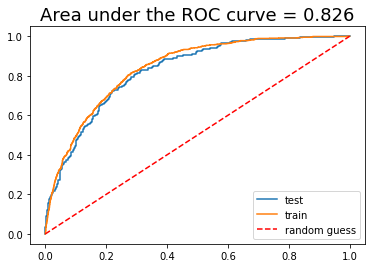

In [ ]:
# SVC with a linear kernel was used here instead of LinearSVC because SVC has a predict_proba method that will allow us to 
# gain more insight on the model's performance
svc_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          ('model', SVC(class_weight='balanced', kernel='linear', probability=True))
                        ])

svc_model = svc_pipeline.fit(train_x, train_y)

get_model_results(svc_model, train_x, test_x, train_y, test_y)


## Logistic regression

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86      1798
         1.0       0.27      0.72      0.39       202

    accuracy                           0.78      2000
   macro avg       0.62      0.75      0.63      2000
weighted avg       0.89      0.78      0.82      2000



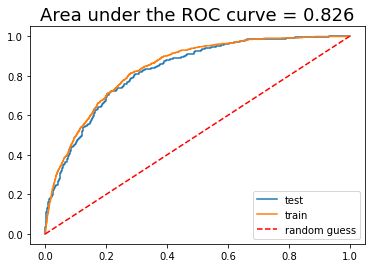

In [ ]:

logreg_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          ('model', LogisticRegression())
                        ])

logreg_model = logreg_pipeline.fit(train_x, train_y)

logreg_model.fit(train_x, train_y)
get_model_results(logreg_model, train_x, test_x, train_y, test_y)

## XGBoost

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83      1798
         1.0       0.24      0.77      0.37       202

    accuracy                           0.73      2000
   macro avg       0.60      0.75      0.60      2000
weighted avg       0.89      0.73      0.78      2000



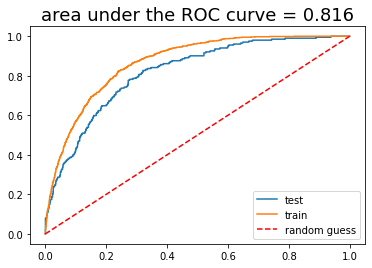

In [ ]:
xgb_pipeline = Pipeline([('processing', preprocessing_pipeline),
                        ('model', XGBClassifier(scale_pos_weight=10))
                        ])

xgb_model = xgb_pipeline.fit(train_x, train_y)
get_model_results(xgb_model, train_x, test_x, train_y, test_y)

All models achieved similar results in terms of ROC AUC, precision and recall.
 Linear SVC had the highest recall for identifying heart disease (0.8 vs. 0.73 and 0.78). Logistic regression had th ehighest weighted average F-score (0.81 vs. 0.77 and 0.78) and weighted average recall (0.77 vs. 0.72 and 0.72). 

# Model interpretation

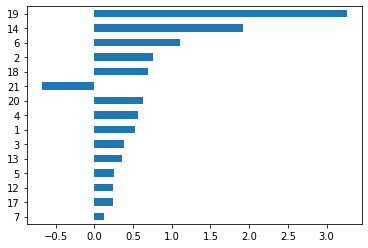

In [ ]:
# preprocessing train_x with pandas to maintain column names for interpretation
impute_num = SimpleImputer(strategy='median')
scaler = MinMaxScaler()
impute_cat = SimpleImputer(strategy='most_frequent')
#ohe = OneHotEncoder(sparse=False)

num_x = impute_num.fit_transform(train_x[numerical_cols])
num_x = scaler.fit_transform(num_x)

cat_x = impute_cat.fit_transform(train_x[categorical_cols])
#cat_x = ohe.fit_transform(cat_x)
train_x_prepared = pd.concat([pd.DataFrame(num_x, columns=numerical_cols), pd.DataFrame(cat_x, columns=categorical_cols)],axis=1)

logreg_pipeline = Pipeline([('processing', preprocessing_pipeline),
                          ('model', LogisticRegression(class_weight='balanced'))
                        ])

logreg_model = logreg_pipeline.fit(train_x, train_y)

feature_importance=pd.DataFrame(index=train_x_prepared.columns, data=logreg_model.named_steps['model'].coef_[0])
feature_importance['abs_value']=feature_importance.abs()
feature_importance.sort_values(by='abs_value')[0].tail(15).plot.barh()
